In [1]:
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt
import certa.metrics

In [2]:
def find_similarities(test_df: pd.DataFrame, m: float, similarity=certa.metrics.get_cosine):
    lprefix = 'ltable_'
    rprefix = 'rtable_'
    ignore_columns = ['id']

    l_columns = [col for col in list(test_df) if (
        col.startswith(lprefix)) and (col not in ignore_columns)]
    r_columns = [col for col in list(test_df) if col.startswith(
        rprefix) and (col not in ignore_columns)]

    l_string_test_df = test_df[l_columns].astype('str').agg(' '.join, axis=1)
    r_string_test_df = test_df[r_columns].astype('str').agg(' '.join, axis=1)
    label_df = test_df['label']

    merged_string = pd.concat(
        [l_string_test_df, r_string_test_df, label_df], ignore_index=True, axis=1)

    sim_df = merged_string.apply(
        lambda x: similarity(x[0], x[1]), axis=1)

    tuples_ls_df = pd.concat([merged_string, sim_df],
                             ignore_index=True, axis=1)

    lpos_df = tuples_ls_df[tuples_ls_df[2] == 1]
    lneg_df = tuples_ls_df[tuples_ls_df[2] == 0]

    theta_max = lpos_df[3].mean() + m * lpos_df[3].std()
    theta_min = lneg_df[3].mean() - m * lneg_df[3].std()

    return theta_min, theta_max

In [3]:
def merge_sources(table, left_prefix, right_prefix, left_source, right_source, copy_from_table, ignore_from_table):
    dataset = pd.DataFrame(
        columns={col: table[col].dtype for col in copy_from_table})
    ignore_column = copy_from_table + ignore_from_table

    for _, row in table.iterrows():
        leftid = row[left_prefix + 'id']
        rightid = row[right_prefix + 'id']

        new_row = {column: row[column] for column in copy_from_table}

        try:
            for id, source, prefix in [(leftid, left_source, left_prefix), (rightid, right_source, right_prefix)]:

                for column in source.keys():
                    if column not in ignore_column:
                        new_row[prefix + column] = source.loc[id][column]

            dataset = dataset.append(new_row, ignore_index=True)
        except:
            pass
    return dataset

### Metric evaluation starts here

In [4]:
datadir = 'datasets/beers/'
lsource = pd.read_csv(datadir + 'tableA.csv')
rsource = pd.read_csv(datadir + 'tableB.csv')
train = pd.read_csv(datadir + 'train.csv')
valid = pd.read_csv(datadir + 'valid.csv')
test = pd.read_csv(datadir + 'test.csv')

In [5]:
train.head()

,ltable_id,rtable_id,label
0,2082,1496,0
1,982,2999,1
2,3715,2562,0
3,3246,284,0
4,1931,810,1


In [6]:
valid_df = merge_sources(valid, 'ltable_', 'rtable_', lsource, rsource, ['label'], ['id'])

In [7]:
test_df = merge_sources(test, 'ltable_', 'rtable_', lsource, rsource, ['label'], ['id'])

In [8]:
train_df = merge_sources(train, 'ltable_', 'rtable_', lsource, rsource, ['label'], ['id'])
train_df.head()

,label,ltable_ABV,ltable_Beer_Name,ltable_Brew_Factory_Name,ltable_Style,rtable_ABV,rtable_Beer_Name,rtable_Brew_Factory_Name,rtable_Style
0,0,8.10 %,C N Red Imperial Red Ale,Redwood Lodge,American Amber / Red Ale,9.30 %,Kinetic Infrared Imperial Red Ale,Kinetic Brewing Company,American Strong Ale
1,1,5.60 %,Sanibel Red Island Ale,Point Ybel Brewing Company,American Amber / Red Ale,5.60 %,Point Ybel Sanibel Red Island Ale,Point Ybel Brewing Company,Irish Ale
2,0,6.80 %,Kniksen India Red Ale,7 Fjell Bryggeri,American Amber / Red Ale,6.50 %,Boneyard Skunkape India Red Ale,Boneyard Beer Company,India Pale Ale &#40; IPA &#41;
3,0,-,Buffalo Trace Bourbon Barrel Aged Amber Ale,Wolf Hills Brewing Company,American Amber / Red Ale,5 %,Ballast Point Calico Amber Ale - Rum Barrel Aged,Ballast Point Brewing Company,Amber Ale
4,1,6.50 %,Poor Richard 's Ale,Dry Dock Brewing Co. .,American Amber / Red Ale,7 %,21st Amendment Poor Richards Ale,21st Amendment Brewery,Traditional Ale


### Makes every row a string instead of multiple columns, leaving the left/right tables separated

In [9]:
df = train_df.copy().astype(str)

l_columns = [col for col in df if col.startswith('ltable_') or col=='label']
r_columns = [col for col in df if col.startswith('rtable_') or col=='label']

df['ltable'] = df.drop(l_columns, axis=1).apply(lambda x: ' '.join(x.values.tolist()), axis=1)
df['rtable'] = df.drop(r_columns, axis=1).apply(lambda x: ' '.join(x.values.tolist()), axis=1)

cols_to_remove = [col for col in l_columns + r_columns if col != 'label']
df_clean = df.drop(cols_to_remove, axis=1)
df_clean.head()

,label,ltable,rtable
0,0,9.30 % Kinetic Infrared Imperial Red Ale Kinet...,8.10 % C N Red Imperial Red Ale Redwood Lodge ...
1,1,5.60 % Point Ybel Sanibel Red Island Ale Point...,5.60 % Sanibel Red Island Ale Point Ybel Brewi...
2,0,6.50 % Boneyard Skunkape India Red Ale Boneyar...,6.80 % Kniksen India Red Ale 7 Fjell Bryggeri ...
3,0,5 % Ballast Point Calico Amber Ale - Rum Barre...,- Buffalo Trace Bourbon Barrel Aged Amber Ale ...
4,1,7 % 21st Amendment Poor Richards Ale 21st Amen...,6.50 % Poor Richard 's Ale Dry Dock Brewing Co...


In [10]:
similarity_functions = [
    certa.metrics.get_cosine,
    certa.metrics.euclidean_distance,
    certa.metrics.minkowski_distance,
    certa.metrics.manhattan_distance,
    certa.metrics.mahalanobis_distance,
    certa.metrics.jaccard_similarity
]

### Calculates the similarity values between the left/right part in each dataframe row

In [11]:
def calculate_similarity_values(df: pd.DataFrame, similarity):
    similarity_values = []
    
    for _, data in df.iterrows():
        l_row = data['ltable']
        r_row = data['rtable']
        similarity_values.append(similarity(l_row, r_row))
        
    return similarity_values

### Normalizes the similarity values to [0,1] interval

In [12]:
def normalize_similarity_values(df: pd.DataFrame):
    similarity_col = df['similarity']
    min_similarity = similarity_col.min()
    max_similarity = similarity_col.max()
    
    if min_similarity < 0:
        similarity_col = similarity_col - min_similarity

    return similarity_col / max_similarity

### Calculates the error between the label and the similarity value

In [13]:
def calculate_error_values(df: pd.DataFrame, squared_error=False):
    error_values = []
    if squared_error:
        power_factor = 2
    else:
        power_factor = 1

    for _, data in df.iterrows():
        label = data['label']
        similarity_value = data['similarity']
        if label == '1':
            error_values.append((int(label) - similarity_value)**power_factor)
        else:
            error_values.append(similarity_value**power_factor)

    return error_values

### Calculates the mean error between the label (0,1) and the similarity value [0,1]

In [14]:
def mean_error(df: pd.DataFrame):
    return df['error'].mean()

### Processes the input dataframe with all the necessary operations

In [15]:
def processing_pipeline(df: pd.DataFrame, metric, squared_error=False):
    df['similarity'] = calculate_similarity_values(df, metric)
    df['similarity'] = normalize_similarity_values(df)
    df['error'] = calculate_error_values(df, squared_error)

    return df   

### Function to plot results

In [16]:
def plot_results(results):
    plt.bar(range(results.shape[0]), results['mean_error'], align='center')
    plt.xticks(range(6), results['metric'], rotation=20)
    #plt.title('Mean Error of similarity metrics evaluating the label')
    plt.show()

### Iterate over all metric functions and save the results, calculate the error as Mean Absolute Error (MAE)

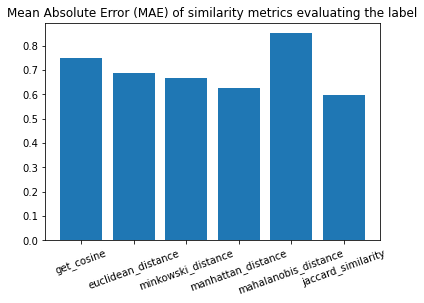

In [17]:
results = pd.DataFrame(columns=['metric', 'mean_error'])

for metric in similarity_functions:
    df_test = df_clean.copy()
    df_test = processing_pipeline(df_test, metric, squared_error=False)
    results = results.append({'metric': metric.__name__, 'mean_error': mean_error(df_test)}, ignore_index=True)

plt.title('Mean Absolute Error (MAE) of similarity metrics evaluating the label')
plot_results(results)

### Iterate over all metric functions and save the results, calculating the error as Mean Squared Error (MSE)

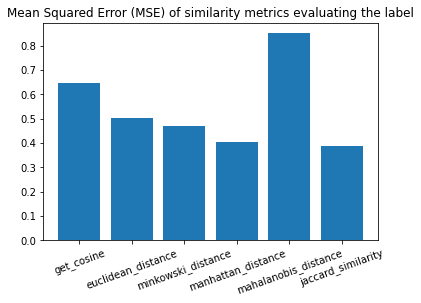

In [18]:
results = pd.DataFrame(columns=['metric', 'mean_error'])

for metric in similarity_functions:
    df_test = df_clean.copy()
    df_test = processing_pipeline(df_test, metric, squared_error=True)
    results = results.append({'metric': metric.__name__, 'mean_error': mean_error(df_test)}, ignore_index=True)

plt.title('Mean Squared Error (MSE) of similarity metrics evaluating the label')
plot_results(results)

**********************************************

### Thresholds normalization (not done) and Prediction Error Count

Analyzing each threshold value for each metric could be useful, just counting how many times the similarity is in the correct range instead of using the mean error

In [19]:
theta_min, theta_max = find_similarities(train_df, -2, certa.metrics.manhattan_distance)
print(theta_min, theta_max)

25.342568729134843 -0.07651535563094036


In [20]:
df_test = df_clean.copy()
df_test.head()

,label,ltable,rtable
0,0,9.30 % Kinetic Infrared Imperial Red Ale Kinet...,8.10 % C N Red Imperial Red Ale Redwood Lodge ...
1,1,5.60 % Point Ybel Sanibel Red Island Ale Point...,5.60 % Sanibel Red Island Ale Point Ybel Brewi...
2,0,6.50 % Boneyard Skunkape India Red Ale Boneyar...,6.80 % Kniksen India Red Ale 7 Fjell Bryggeri ...
3,0,5 % Ballast Point Calico Amber Ale - Rum Barre...,- Buffalo Trace Bourbon Barrel Aged Amber Ale ...
4,1,7 % 21st Amendment Poor Richards Ale 21st Amen...,6.50 % Poor Richard 's Ale Dry Dock Brewing Co...


In [21]:
def normalize_similarity_thresholds(df: pd.DataFrame, theta_min, theta_max):
    similarity_col = df['similarity']
    min_similarity = similarity_col.min()
    max_similarity = similarity_col.max()
    
    if min_similarity < 0:
        similarity_col = similarity_col - min_similarity
        theta_min -= min_similarity
        theta_max -= min_similarity
        
    similarity_col = similarity_col / max_similarity
    theta_min /= max_similarity
    theta_max /= max_similarity

    return (similarity_col, theta_min, theta_max)

### Prediction Error Count

When searching for w to build triangles the system needs to estimate if the pair (u,w) matches or not (depending on the triangle type) to avoid using the deep model to do so. 

To estimate the correctness of this selection process we use the training set labels (match=1, non-match=0) which are not available in production (using the deep model prediction instead).

When trying to select a matching pair (label=1) the function checks if the similarity > theta_max (or viceversa), which would be good, otherwise it returns 1 to signal an error (wasted pair that could have been used)

In [22]:
def count_similarity_threshold_errors(df: pd.DataFrame, theta_min, theta_max):
    error_values = []

    for _, data in df.iterrows():
        label = data['label']
        similarity_value = data['similarity']
        if label == '1':      
            error_values.append(int(similarity_value < theta_max))
        else:
            error_values.append(int(similarity_value > theta_min))

    return error_values

### It is a better idea to remove normalization and count the prediction errors with my varying

In [23]:
def processing_pipeline_thresholds(df: pd.DataFrame, metric, m, theta_min, theta_max):
    df['similarity'] = calculate_similarity_values(df, metric)
    #similarity_col, theta_min, theta_max = normalize_similarity_thresholds(df, theta_min, theta_max)
    #print(theta_min, theta_max, metric.__name__)
    #df['similarity'] = similarity_col
    df['prediction_error'] = count_similarity_threshold_errors(df, theta_min, theta_max)

    return df 

In [24]:
def cumulate_error(df: pd.DataFrame):
    return df['prediction_error'].sum()

In [25]:
def plot_results_thresholds(results, m):
    plt.bar(range(results.shape[0]), results['prediction_error_count'], align='center')
    plt.xticks(range(6), results['metric'], rotation=20)
    plt.title('Prediction Error Count of similarity metrics evaluating the label with thresholds with m = ' + str(m))
    plt.show()

In [26]:
m_values = range(-5, 6)
results = pd.DataFrame(columns=['metric', 'prediction_error_count'])

for m in m_values:

    for metric in similarity_functions:
        df_test = df_clean.copy()
        theta_min, theta_max = find_similarities(train_df, m, metric)
        df_test = processing_pipeline_thresholds(df_test, metric, m , theta_min, theta_max)
        results = results.append({'metric': metric.__name__, 'prediction_error_count': cumulate_error(df_test), 'm': m}, ignore_index=True)

    #plot_results_thresholds(results, m)

In [27]:
results

,metric,prediction_error_count,m
0,get_cosine,0,-5.0
1,euclidean_distance,0,-5.0
2,minkowski_distance,0,-5.0
3,manhattan_distance,0,-5.0
4,mahalanobis_distance,0,-5.0
...,...,...,...
61,euclidean_distance,268,5.0
62,minkowski_distance,268,5.0
63,manhattan_distance,268,5.0
64,mahalanobis_distance,268,5.0


In [28]:
def plot_results_thresholds_total(results):
    plt.figure(figsize=(12,6))
    ax = plt.axes()
    ax.set(xlim=(-5, 5), xlabel='m', ylabel='Prediction Error Count');
    
    for metric in results['metric'].unique():
        current_metric_results = results[results['metric'].str.contains(metric)]
        plt.plot(current_metric_results['m'], current_metric_results['prediction_error_count'], label=str(metric))
        
    plt.title('Prediction Error Count of the metrics varying m')
    plt.legend(loc='best')
    plt.show()

### The more m increases the more the stricter the thresholds are (makes sense that the errors increase)

However one can't decrease m indefinitely, as the choice if a pair is match/non-match will be almost random.

A good value seems to be m = -1, which could be tested in the benchmark notebook.

The outputs seem to follow a logistic curve trend (some of which are shifted earlier/later)

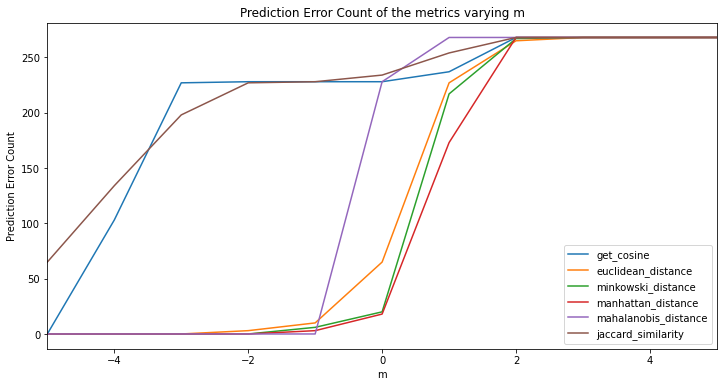

In [29]:
plot_results_thresholds_total(results)